In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import random as rnd #generador de números aleatorios

### Anexo al trabajo académico: Estudio del modelo de Ising en dos dimensiones empleando simulaciones computacionales

#### Por: Debinamaca Ainoo, Marcos Molina, Matilde Osa, Mateo Regal, Marco Nieto y Lluís Mompó.

La configuración y programación del modelo de Ising 2D se ha realizado mediante el lenguaje de programación Python. La parte numérica del programa se ha implementado utilizando el algoritmo de Metropolis basado en el método de Montecarlo.

Partimos de la expresión: $lnZ = Nln[\sqrt{2}cosh(\beta J)] + \frac{N}{\pi}\int_{0}^{\pi/2}ln\left(1+ \sqrt{1-\kappa^2sin^2(\phi})\right) d\phi$

In [2]:
beta, J, kappa, N, phi, kb, T = sp.symbols('beta J kappa N phi k_b T')

#calculamos la regla de la cadena
kappa_ = (2*sp.sinh(2*beta*J))/(sp.cosh(2*beta*J)**2)
cadena = sp.diff(kappa_, beta)

#definimos el integrando
expresion_integrando = sp.ln(1+sp.sqrt(1-kappa**2*sp.sin(phi)**2))

#derivada del integrando respecto de beta, aplicando regla de la cadena
dint_dbeta = sp.simplify(cadena*sp.diff(expresion_integrando, kappa))

dint_dbeta


4*J*kappa*(2*sinh(2*J*beta)**2 - cosh(2*J*beta)**2)*sin(phi)**2/((-kappa**2*sin(phi)**2 + sqrt(-kappa**2*sin(phi)**2 + 1) + 1)*cosh(2*J*beta)**3)

In [3]:
a = sp.symbols('a')
integrado_phi = sp.integrate(dint_dbeta, (phi, 0, a))
integrado_phi

4*J*kappa*(-2*sinh(2*J*beta)**2 + cosh(2*J*beta)**2)*Integral(sin(phi)**2/(kappa**2*sin(phi)**2 - sqrt(-kappa**2*sin(phi)**2 + 1) - 1), (phi, 0, a))/cosh(2*J*beta)**3

Calculamos la energía interna por partícula, $e = \frac{E}{N} = -\frac{1}{N}\left(\frac{\partial lnZ}{\partial \beta} \right)$

In [4]:
#lnZ posee 2 términos: lnZ = Nln(2cosh(beta J)) + N/2pi * integral_phi
#Una vez calculada la integral_phi respecto del integrando derivado respecto de beta, para hallar E solo necesitamos 
# calcular la derivada respecto de beta del primer término y sumar ambos multiplicados por un factor -1.
e = -((sp.diff(sp.ln(sp.sqrt(2)*sp.cosh(2*beta*J)), beta))+(1/(sp.pi))*integrado_phi)
e

-4*J*kappa*(-2*sinh(2*J*beta)**2 + cosh(2*J*beta)**2)*Integral(sin(phi)**2/(kappa**2*sin(phi)**2 - sqrt(-kappa**2*sin(phi)**2 + 1) - 1), (phi, 0, a))/(pi*cosh(2*J*beta)**3) - 2*J*sinh(2*J*beta)/cosh(2*J*beta)

Reescribimos en términos de la integral elíptica completa de primera clase: $e=-2J tanh(2K) - \frac{J(sinh^2(2K)-1)}{cosh(2K)sinh(2K)}\left(\frac{2}{\pi}K_1(\kappa) - 1\right)$

In [5]:
from sympy import elliptic_f, I

e=-2*J*sp.tanh(2*beta*J) - (J*(sp.sinh(2*beta*J)**2-1))/(sp.cosh(2*beta*J)*sp.sinh(2*beta*J))*((2*elliptic_f(sp.pi/2, kappa))/sp.pi-1)
e

-J*(2*elliptic_k(kappa)/pi - 1)*(sinh(2*J*beta)**2 - 1)/(sinh(2*J*beta)*cosh(2*J*beta)) - 2*J*tanh(2*J*beta)

Calor específico por partícula: $c = \left(\frac{\partial e}{\partial T} \right)$

In [6]:
#derivamos la expresión anterior
c = sp.diff(e.subs(kappa, kappa_).subs(beta, 1/(kb*T)), T).subs(1/(kb*T), beta).subs(kappa_,kappa)
c

4*J**2*beta*(1 - tanh(2*J*beta)**2)/T - 2*J**2*beta*(2*elliptic_k(kappa)/pi - 1)*(sinh(2*J*beta)**2 - 1)/(T*cosh(2*J*beta)**2) - 2*J**2*beta*(2*elliptic_k(kappa)/pi - 1)*(sinh(2*J*beta)**2 - 1)/(T*sinh(2*J*beta)**2) + 4*J**2*beta*(2*elliptic_k(kappa)/pi - 1)/T - J*(-(1 - kappa)*elliptic_k(kappa) + elliptic_e(kappa))*(4*J*beta*kappa*sinh(2*J*beta)/(T*cosh(2*J*beta)) - 4*J*beta/(T*cosh(2*J*beta)))*(sinh(2*J*beta)**2 - 1)*cosh(2*J*beta)/(2*pi*(1 - kappa)*sinh(2*J*beta)**2)

Magnetización (extraída de: C. N. Yang. The spontaneous magnetization of a two-dimensional ising model. Phys. Rev., 85:808–816, Mar 1952)

In [7]:
#Es una función definida a trozos, el tramo T<Tc se define como
m = (1- sp.sinh(2*J*beta)**(-4))**(1/8)
m
#El tramo T>Tc es simplemente 0

(1 - 1/sinh(2*J*beta)**4)**0.125

Susceptibilidad (extraído de: Tai Tsun Wu, Barry M. McCoy, Craig A. Tracy, and Eytan Barouch. Spin-
spin correlation functions for the two-dimensional ising model: Exact
theory in the scaling region. Phys. Rev. B, 13:316–374, Jan 1976)

In [8]:
mu, Tc, Cp, Cm= sp.symbols('mu T_c C_+ C_-')
#Función definida a trozos, denotados por x1 y x2
x1 = N*mu**2/(kb*T) * Cp*((T-Tc)/Tc)**(-4/7)
x2 = N*mu**2/(kb*T) * Cm*(abs(T-Tc)/Tc)**(-4/7)
x2

C_-*N*mu**2*(1/T_c)**(-0.571428571428571)*Abs(T - T_c)**(-0.571428571428571)/(T*k_b)

## Parte Numérica

In [9]:
def Ising2D_sincampo(kb,J,T,L, itera):
    s = np.ones((L,L))*(-1) #vector de espines inicializado en el estado fundamental (todos los espines apuntan en la misma dirección)
    #todos apuntan en el mínimo valor para evitar errores a la hora de usar la función plt.imshow para el estado inicial
    N = L**2 #número total de espines

    mallas = [] #lista donde se almacenan las diversas fotografias a lo largo de las iteraciones
    mallas.append(abs(s.copy())) #sacamos la foto inicial
    timestamp1 = False #bandera para asegurarse que solo se tome una foto en el momento 1
    timestamp2 = False #bandera para asegurarse que solo se tome una foto en el momento 2

    suma0 = 0
    for j in range(L):
        for i in range(L-1):
            suma0+=s[i][j]*s[i+1][j] #interacción del espin con su vecino de la derecha
        suma0+=s[L-1][j]*s[0][j] #caso especial para el último espin de la cadena
    for i in range(L):
        for j in range(L-1):
            suma0+=s[i][j]*s[i][j+1] #interacción del espin con su vecino de arriba
        suma0+=s[i][0]*s[i][L-1] #caso especial para el último espin de la cadena

    E = -J*suma0 #Calculamos la energía total del sistema
    n = 0 #número iteraciones
    E_s=[] #vector que almacena las energías en cada configuración
    M=[] #un vector que almacena la magnetización de cada configuración
    while n<itera:
        r = rnd.randint(0,L-1)
        l = rnd.randint(0,L-1)
        s[r][l]*=-1  #se elige un espín al azar y se cambia su valor
        suma1 = 0
        #recalculamos la energía del sistema
        for j in range(L):
            for i in range(L-1):
                suma1+=s[i][j]*s[i+1][j]
            suma1+=s[L-1][j]*s[0][j]
        for i in range(L):
            for j in range(L-1):
                suma1+=s[i][j]*s[i][j+1]
            suma1+=s[i][0]*s[i][L-1]

        E1 = -J*suma1  #Se calcula la energía de la nueva configuración
        dE = E1-E
        if dE <=0:
            E += dE #se acepta el cambio
            M.append(np.mean(s))
        elif dE>0:
            p = np.exp(-dE/(kb*T)) #se acepta el cambio con la probabilidad p
            t = rnd.random() #generamos num aleatorio
            if t<=p:
                E += dE #se acepta el cambio
                M.append(np.mean(s))
            else:
                s[r][l]*=-1  #no se acepta el cambio

        E_s.append(E) #almacenamos la energía #almacenamos la magnetización
        n+=1

        if n>itera/3 and timestamp1==False:
            timestamp1 = True
            mallas.append(s.copy()) #sacamos foto en el momento intermedio 1
        if n>2*itera/3 and timestamp2==False:
            timestamp2 = True
            mallas.append(s.copy()) #sacamos foto en el momento intermedio 2

    mallas.append(s.copy()) #sacamos foto en el momento final

    E_s2 = []  #se crea un vector donde se almacena la energía al cuadrado por partícula
    for i in range(len(E_s)):
        E_s2.append((E_s[i]/N)**2) 
    E_s2media = np.mean(E_s2)  
    c = (E_s2media-(np.mean(E_s)/N)**2)/(kb*T**2) #capacidad calorífica
    
    M_ = np.mean(M) #magnetización media
    sum = 0
    for i in range(len(M)):
        sum+=M[i]**2
    M_2 = sum/len(M)
    X = (M_2-M_**2)/(T*kb) #susceptibilidad
    
    mcs = n #total de intentos de cambio por espín
    r = len(M) #iteraciones en las que el cambio fue aceptado
    rpc = (r/mcs)*100
    
    return np.mean(E_s)/N, c*N, X*N, abs(M_), mallas

In [10]:
def Ising2d_plot_sincampo(kb,J,L, arrayT, analiticT, itera, Tmalla1, Tmalla2):
    E_T = []
    C_T = []
    X_T = []
    M_T = []
    for i in range(len(arrayT)):
        E_media, C, X, M, mallas = Ising2D_sincampo(kb,J,arrayT[i],L, itera) #Evaluamos la función para cada temperatura
        E_T.append(E_media)
        C_T.append(C)
        X_T.append(X)
        M_T.append(M)
    
    E_media, C, X, M, mallas1 = Ising2D_sincampo(kb,J,Tmalla1,L, itera) #Evaluamos al modelo en T=Tmalla1 para capturar su evolución antes de Tc
    E_media, C, X, M, mallas2 = Ising2D_sincampo(kb,J,Tmalla2,L, itera) #Evaluamos al modelo en T=Tmalla2 para capturar su evolución después de Tc

    #Graficamos los valores obtenidos

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(26,5))
    beta,J,kb,N,T,h = sp.symbols('beta,J,k_b,N,T,h')
    #fig.suptitle('Dependencias con la temperatura de diferentes magnitudes (por partícula)', fontsize = 15, fontweight='demi')

    #graficamos las expresiones de la energía por particula empleando bucles
    ax1.text(0.82, 0.13, 'Energía', fontsize = 13, transform=ax1.transAxes,  fontweight='550')
    ax1.set_ylabel('$E \,(J \, part^{-1}) $', fontsize = 14)
    ax1.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    ax1.plot(arrayT,E_T)
    e_graph = e.subs(kappa, kappa_).subs(beta, 1/(kb*T)).subs(J,1).subs(kb, 1)
    e_vals = []
    for i in range(len(analiticT)):
        e_vals.append(e_graph.subs(T,analiticT[i]))
    ax1.plot(analiticT,e_vals, 'k')
    ax1.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.4', label='Tc = 2.269 J/$k_B$')
    ax1.legend()
    

    #graficamos las expresiones del calor específico por particula empleando bucles
    ax2.text(0.65, 0.85, 'Calor específico', fontsize = 13, transform=ax2.transAxes,  fontweight='550')
    ax2.set_ylabel('$C \,(J \, kg^{-1} \,K^{-1} \,part^{-1})$', fontsize = 14)
    ax2.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    ax2.plot(arrayT,C_T, 'tab:red')
    c_graph = c.subs(kappa, kappa_).subs(beta, 1/(kb*T)).subs(J,1).subs(kb, 1)
    c_vals = []
    for i in range(len(analiticT)):
        c_vals.append(c_graph.subs(T,analiticT[i]))
    ax2.plot(analiticT,c_vals,'k')
    ax2.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.4', label='Tc = 2.269 J/$k_B$')
    ax2.legend()
    

    #graficamos las expresiones de la susceptibilidad magnética por particula empleando bucles

    ax3.text(0.66, 0.79, 'Susceptibilidad \n       magnética', fontsize = 13, transform=ax3.transAxes,  fontweight='550')
    ax3.set_ylabel('$\chi \, (H \, m^{-1} \, part^{-1})$', fontsize = 14)
    ax3.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    ax3.plot(arrayT,X_T, 'tab:orange')
    x1_graph = x1.subs(J,1).subs(kb, 1).subs(Cp, 0.96258).subs(Tc, (2/np.log(1+np.sqrt(2)))).subs(N,2).subs(mu,1)
    x2_graph = x2.subs(J,1).subs(kb, 1).subs(Cm, 0.02554).subs(Tc, (2/np.log(1+np.sqrt(2)))).subs(N,2).subs(mu,1)
    x_vals = []
    for i in range(len(analiticT)):
        if analiticT[i] <= 2/np.log(1+np.sqrt(2)) :
            x_vals.append(x2_graph.subs(T,analiticT[i]))
        else:
            x_vals.append(x1_graph.subs(T,analiticT[i]))
    x_vals[0]=x_vals[1]
    ax3.plot(analiticT,x_vals,'k')
    ax3.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.4', label='Tc = 2.269 J/$k_B$')
    ax3.legend()
    

    #graficamos las expresiones de la magnetización por particula empleando bucles
    ax4.text(0.68, 0.85, 'Magnetización', fontsize = 13, transform=ax4.transAxes,  fontweight='550')
    ax4.set_ylabel('$M \, (A \, m^{-1} \, part^{-1}) $', fontsize = 14)
    ax4.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    ax4.plot(arrayT,M_T, 'tab:green')
    m_graph = m.subs(beta, 1/(kb*T)).subs(J,1).subs(kb, 1)
    m_vals = []
    for i in range(len(analiticT)):
        value = m_graph.subs(T,analiticT[i])
        if type(value) == sp.core.numbers.Float or type(value) == sp.core.numbers.NaN :
            m_vals.append(value)
        else:
            m_vals.append(0)
    ax4.plot(analiticT,m_vals, 'k')
    ax4.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.4', label='Tc = 2.269 J/$k_B$')
    ax4.legend()
    plt.show()

    #grafica para las fotografias en determinados instantes de tiempo

    fig, axs = plt.subplots(2, 4, figsize=(12, 7))  # Create a figure with 2 rows and 4 columns
    fig.subplots_adjust(bottom=0.2)  # Adjust the bottom margin for the colorbar
    #fig.suptitle('Configuración de los espines a lo largo de las iteraciones', fontsize = 15, fontweight='demi')

    # Graficamos configuraciones de la fila superior
    axs[0, 0].imshow(mallas1[0], cmap = 'coolwarm')
    axs[0, 0].set_title('Inicial, T<$T_c$', fontsize = 12)

    axs[0, 1].imshow(mallas1[1], cmap = 'coolwarm')
    axs[0, 1].set_title('1/3 iteraciones, T<$T_c$', fontsize = 12)

    axs[0, 2].imshow(mallas1[2], cmap = 'coolwarm')
    axs[0, 2].set_title('2/3 iteraciones, T<$T_c$', fontsize = 12)

    axs[0, 3].imshow(mallas1[3], cmap = 'coolwarm')
    axs[0, 3].set_title('Final, T<$T_c$', fontsize = 12)

    # Graficamos configuraciones de la fila inferior
    axs[1, 0].imshow(mallas2[0], cmap = 'coolwarm')
    axs[1, 0].set_title('Inicial, T>$T_c$', fontsize = 12)

    axs[1, 1].imshow(mallas2[1], cmap = 'coolwarm')
    axs[1, 1].set_title('1/3 iteraciones, T>$T_c$', fontsize = 12)

    axs[1, 2].imshow(mallas2[2], cmap = 'coolwarm')
    axs[1, 2].set_title('2/3 iteraciones, T>$T_c$', fontsize = 12)

    axs[1, 3].imshow(mallas2[3], cmap = 'coolwarm')
    axs[1, 3].set_title('Final, T>$T_c$', fontsize = 12)

    # Creamos una colorbar
    cax = fig.add_axes([0.2, 0.1, 0.6, 0.05]) 
    cbar = plt.colorbar(axs[0, 3].imshow(mallas1[3], cmap = 'coolwarm'), cax=cax, orientation='horizontal')

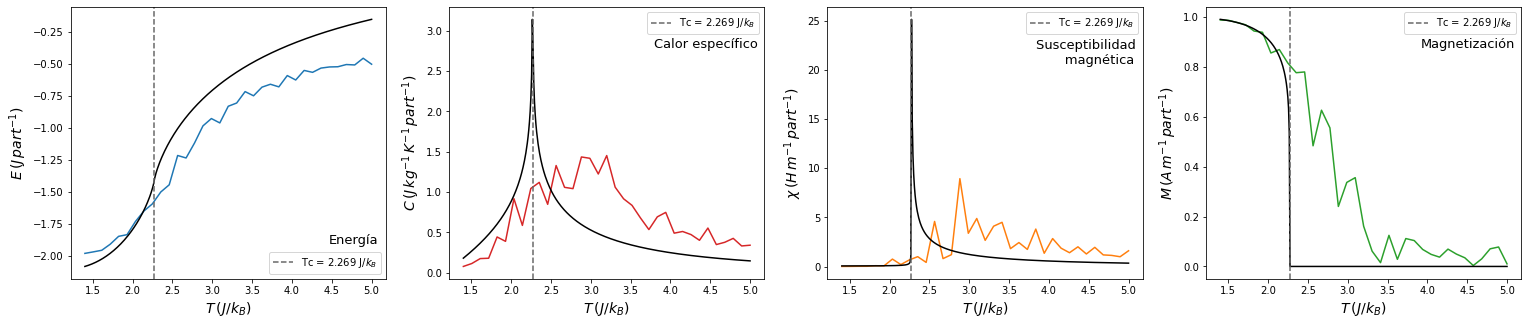

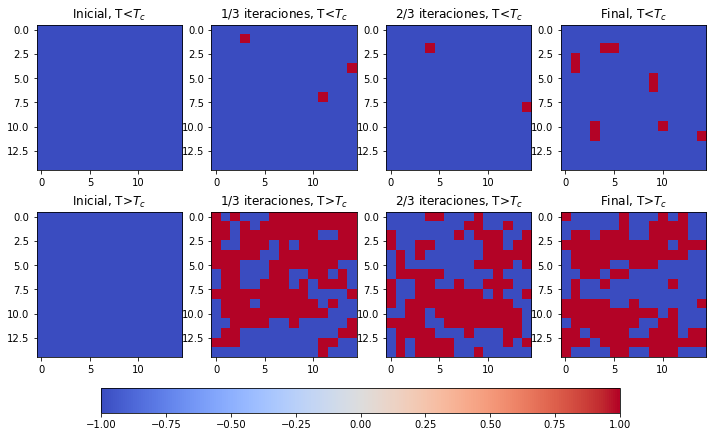

In [19]:
kb = 1
J = 1
L = 15
arrayT = np.linspace(1.4,5,35)
arrayTanalitica = np.linspace(1.4, 5, 400) #para una gráfica correcta, arrayT y arrayTanalitica deben tomar puntos en un mismo intervalo
itera = 10000
Tmalla1 = 2 #para visualizar evolucion del sistema antes de Tc
Tmalla2 = 4 #para visualizar evolucion del sistema despues de Tc
Ising2d_plot_sincampo(kb,J,L, arrayT,arrayTanalitica, itera, Tmalla1, Tmalla2) 
#Es altamente improbable que aparezca un error de division entre 0 para un alto número de iteraciones y partículas
#(se da cuando no se producen cambios) -> si ocurre, volver a ejecutar la función o aumentar itera/L

In [20]:
def sincampo_variapartic(kb, J, arrayT,  analiticT, arrayL, itera):
    X_Ts = []
    C_Ts = []
    colors = ['red', 'blue', 'green', 'orange']
    
    #llamamos a la función que calcula el algoritmo de ising sin campo con cada uno de los diferentes valores de N y de T
    for j in range(len(arrayL)):
        X_T = []
        C_T = []
        for i in range(len(arrayT)):
            E_media, C, X, M, mallas = Ising2D_sincampo(kb,J,arrayT[i],arrayL[j], itera)
            X_T.append(X)
            C_T.append(C)
        X_Ts.append(X_T)
        C_Ts.append(C_T)

    #Graficamos los valores obtenidos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5,4.7))
    beta,J,k_b,N,T,h = sp.symbols('beta,J,k_b,N,T,h')
    
    #graficamos las expresiones del calor específico por particula empleando bucles
    ax1.text(0.41, 0.94, 'Calor específico', fontsize = 13, transform=ax1.transAxes,  fontweight='550')
    ax1.set_ylabel('$C \,(J \, kg^{-1} \,K^{-1} \,part^{-1})$', fontsize = 14)
    ax1.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    for i in range(len(arrayL)):  
        ax1.plot(arrayT,C_Ts[i], f'tab:{colors[i]}', label = f'L = {arrayL[i]}')
        
    c_graph = c.subs(kappa, kappa_).subs(beta, 1/(kb*T)).subs(J,1).subs(kb, 1)
    c_vals = []
    for i in range(len(analiticT)):
        c_vals.append(c_graph.subs(T,analiticT[i]))
    ax1.plot(analiticT,c_vals,'k')   
    ax1.legend(loc='upper right')

    #graficamos las expresiones de la susceptibilidad magnética empleando bucles
    

    ax2.text(0.43, 0.88, 'Susceptibilidad \n       magnética', fontsize = 13, transform=ax2.transAxes,  fontweight='550')
    ax2.set_ylabel('$\chi \, (H \, m^{-1} \, part^{-1})$', fontsize = 14)
    ax2.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    for i in range(len(arrayL)):
        ax2.plot(arrayT,X_Ts[i], f'tab:{colors[i]}', label = f'L = {arrayL[i]}')

    x1_graph = x1.subs(J,1).subs(k_b, 1).subs(Cp, 0.96258).subs(Tc, (2/np.log(1+np.sqrt(2)))).subs(N,2).subs(mu,1)
    x2_graph = x2.subs(J,1).subs(k_b, 1).subs(Cm, 0.02554).subs(Tc, (2/np.log(1+np.sqrt(2)))).subs(N,2).subs(mu,1)
    x_vals = []
    for i in range(len(analiticT)):
        if analiticT[i] <= 2/np.log(1+np.sqrt(2)) :
            x_vals.append(x2_graph.subs(T,analiticT[i]))
        else:
            x_vals.append(x1_graph.subs(T,analiticT[i]))
    x_vals[0]=x_vals[1]
    ax2.plot(analiticT,x_vals, 'k')
    ax2.legend(loc='upper right')

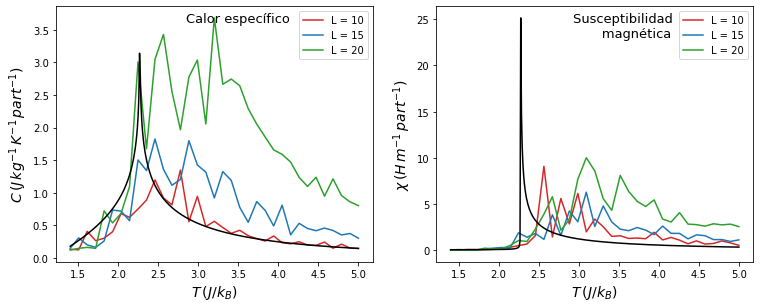

In [21]:
J=1
kb=1
itera = 10000
L = [10,15,20]
arrayT = np.linspace(1.4,5,35)
arrayTanalitica = np.linspace(1.4, 5, 400) #para una gráfica correcta, arrayT y arrayTanalitica deben tomar puntos en un mismo intervalo 
sincampo_variapartic(kb, J, arrayT, arrayTanalitica, L, itera)

In [22]:
def Ising2D_concampo(kb,J,T,L,h,itera):
    s = np.ones((L,L)) #vector de espines inicializado en el estado fundamental (todos los espines apuntan en la misma dirección)
    size = s.shape[0]
    N = L**2 #nº de espines
    suma0 = 0
    sumh = 0
    #Calculamos la energía del sistema teniendo en cuenta la interacción con los vecinos
    for i in range(L):
        for j in range(L):
            suma0 += 0.5*s[i][j]*(s[(i-1)%size][j]+s[(i+1)%size][j]+s[i][(j-1)%size]+s[i][(j+1)%size])
    for i in range(L):
        for j in range(L):
            sumh+=s[i][j]
    E = -J*suma0-h*sumh #Calculamos la energía total del sistema
    n = 0 #número iteraciones
    E_s=[] #vector que almacena las energías en cada configuración
    M=[] #un vector que almacena la magnetización de cada configuración
    while n<itera:
        r = rnd.randint(0,L-1)
        l = rnd.randint(0,L-1)
        s[r][l]*=-1  #se elige un espín al azar y se cambia su valor
        suma1 = 0
        sumh1 = 0
        #Se calcula la energía de la nueva configuración
        for i in range(L):
            for j in range(L):
                suma1 += 0.5*s[i][j]*(s[(i-1)%size][j]+s[(i+1)%size][j]+s[i][(j-1)%size]+s[i][(j+1)%size])
        for i in range(L):
            for j in range(L):
                sumh1+=s[i][j]
        E1 = -J*suma1-h*sumh1  
        dE = E1-E
        if dE <=0:
            E += dE #se acepta el cambio
        elif dE>0:
            p = np.exp(-dE/(kb*T)) #se acepta el cambio con la probabilidad p
            t = rnd.random() #generamos num aleatorio
            if t<=p:
                E += dE #se acepta el cambio

            else:
                s[r][l]*=-1 #no se acepta el cambio

        E_s.append(E) #almacenamos la energía
        M.append(np.mean(s)) #almacenamos la magnetización
        n+=1

    E_s2 = []  #se crea un vector donde se almacena la energía al cuadrado por partícula
    for i in range(len(E_s)):
        E_s2.append((E_s[i]/N)**2) 
    E_s2media = np.mean(E_s2)  
    c = (E_s2media-(np.mean(E_s)/N)**2)/(kb*T**2) #capacidad calorífica
    
    M_ = np.mean(M) #magnetización media
    sum = 0
    for i in range(len(M)):
        sum+=M[i]**2
    M_2 = sum/len(M)
    X = (M_2-M_**2)/(T*kb) #susceptibilidad
    
    return np.mean(E_s)/N, N*c, N*X, M_

In [23]:
def Ising2d_plot_concampo(kb,J,L, arrayT, itera, h):
    E_T = []
    C_T = []
    X_T = []
    M_T = []
    maxvalc = 0
    tcrit = 0
    for i in range(len(arrayT)):
        E_media, C, X, M = Ising2D_concampo(kb,J,arrayT[i],L, h, itera) #Evaluamos la función para cada temperatura
        if C > maxvalc:
            maxvalc = C
            tcrit = arrayT[i]
        E_T.append(E_media)
        C_T.append(C)
        X_T.append(X)
        M_T.append(M)

    #Graficamos los valores obtenidos
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(26,5))
    beta,J,kb,N,T,h = sp.symbols('beta,J,k_b,N,T,h')

    #graficamos las expresiones de la energía por particula empleando bucles
    ax1.text(0.82, 0.19, 'Energía', fontsize = 13, transform=ax1.transAxes,  fontweight='550')
    ax1.set_ylabel('$E \,(J \, part^{-1}) $', fontsize = 14)
    ax1.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    ax1.plot(arrayT,E_T)

    ax1.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.7', label='Tc = 2.269 J/$k_B$')
    ax1.axvline(x=tcrit,linestyle= 'dashed', color='#704141', label=f'Tc\' = {tcrit:.3f} J/$k_B$')
    ax1.legend(loc='lower right')
    

    #graficamos las expresiones del calor específico por particula empleando bucles
    ax2.text(0.65, 0.77, 'Calor específico', fontsize = 13, transform=ax2.transAxes,  fontweight='550')
    ax2.set_ylabel('$C \,(J \, kg^{-1} \,K^{-1} \,part^{-1})$', fontsize = 14)
    ax2.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    ax2.plot(arrayT,C_T, 'tab:red')
    
    ax2.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.7', label='Tc = 2.269 J/$k_B$')
    ax2.axvline(x=tcrit,linestyle= 'dashed', color='#704141', label=f'Tc\' = {tcrit:.3f} J/$k_B$')
    ax2.legend(loc='upper right')
    

    #graficamos las expresiones de la susceptibilidad magnética por particula empleando bucles

    ax3.text(0.66, 0.72, 'Susceptibilidad \n       magnética', fontsize = 13, transform=ax3.transAxes,  fontweight='550')
    ax3.set_ylabel('$\chi \, (H \, m^{-1} \, part^{-1})$', fontsize = 14)
    ax3.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    ax3.plot(arrayT,X_T, 'tab:orange')
    
    ax3.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.7', label='Tc = 2.269 J/$k_B$')
    ax3.axvline(x=tcrit,linestyle= 'dashed', color='#704141', label=f'Tc\' = {tcrit:.3f} J/$k_B$')
    ax3.legend(loc='upper right')
    

    #graficamos las expresiones de la magnetización por particula empleando bucles
    ax4.text(0.68, 0.77, 'Magnetización', fontsize = 13, transform=ax4.transAxes,  fontweight='550')
    ax4.set_ylabel('$M \, (A \, m^{-1} \, part^{-1}) $', fontsize = 14)
    ax4.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    ax4.plot(arrayT,M_T, 'tab:green')
    
    ax4.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.7', label='Tc = 2.269 J/$k_B$')
    ax4.axvline(x=tcrit,linestyle= 'dashed', color='#704141', label=f'Tc\' = {tcrit:.3f} J/$k_B$')
    ax4.legend(loc='upper right')
    plt.show()


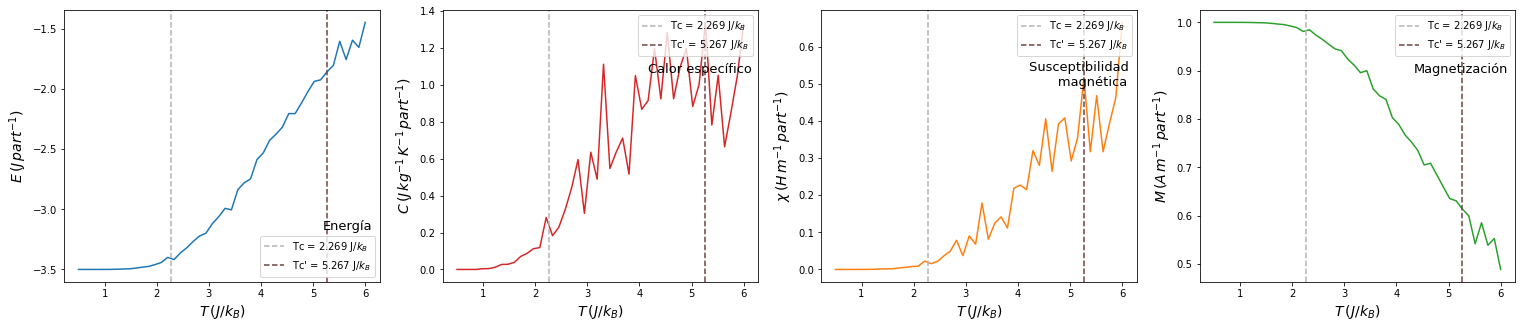

In [24]:
h = 1.5
J=1
kb=1
L = 20
itera = 20000
arrayT = np.linspace(0.5,6,46)
Ising2d_plot_concampo(kb,J,L, arrayT, itera,h) 
#Es altamente improbable que aparezca un error de division entre 0 para un alto número de iteraciones y partículas
#(se da cuando no se producen cambios) -> si ocurre, volver a ejecutar la función o aumentar itera/L

In [25]:
def variacampo(kb, J, arrayT, L, itera, arrayh):
    E_Ts = []
    M_Ts = []
    X_Ts = []
    C_Ts = []
    criticas=[]
    cols1=['#001420','#003b60','#0089df','#78cbff']
    cols2=['#200001','#600004','#DF000A','#ff4f57']
    cols3=['#201300','#603900','#DF8600','#ffbd59']
    cols4=['#002004','#00600C','#00DF1C','#5cff7a']
    
    #llamamos a la función que calcula el algoritmo de ising sin campo con cada uno de los diferentes valores de h y de T
    for j in range(len(arrayh)):
        X_T = []
        C_T = []
        E_T = []
        M_T = []
        maxvalc = 0
        maxvalx = 0
        for i in range(len(arrayT)):
            E_media, C, X, M = Ising2D_concampo(kb,J,arrayT[i],L,arrayh[j], itera,)
            if C > maxvalc: #calculamos en que T se da la máxima capacidad calorífica
                maxvalc = C
                tcritc = arrayT[i]
            X_T.append(X)
            C_T.append(C)
            E_T.append(E_media)
            M_T.append(M)
        X_Ts.append(X_T)
        C_Ts.append(C_T)
        E_Ts.append(E_T)
        M_Ts.append(M_T)

        criticas.append(tcritc) #estimamos Tc en el valor máximo de la capacidad calorífica

    #Graficamos los valores obtenidos

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(26,5))
    ax1.axvline(x=2/np.log(1+np.sqrt(2)), linestyle= 'dashed', color='0.7')
    ax2.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.7')
    ax3.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.7')
    ax4.axvline(x=2/np.log(1+np.sqrt(2)),linestyle= 'dashed', color='0.7')

    #graficamos las expresiones de la energía por particula empleando bucles
    ax1.text(0.02, 0.70, 'Energía', fontsize = 13, transform=ax1.transAxes,  fontweight='550')
    ax1.set_ylabel('$E \,(J \, part^{-1}) $', fontsize = 14)
    ax1.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    for i in range(len(arrayh)):
        ax1.plot(arrayT,E_Ts[i], cols1[i], label = f'H ={arrayh[i]}')
        ax1.axvline(x=criticas[i], linestyle= 'dashed', color=cols1[i])
    ax1.legend(loc='upper left')
    for i in range(len(criticas)):
        ax1.text(criticas[i]+0.01, -3.2, f'$Tc$ = {criticas[i]:.3f}', rotation=90, fontweight='demi', fontsize='9')
    

    #graficamos las expresiones del calor específico por particula empleando bucles
    ax2.text(0.02, 0.70, 'Calor específico', fontsize = 13, transform=ax2.transAxes,  fontweight='550')
    ax2.set_ylabel('$C \,(J \, kg^{-1} \,K^{-1} \,part^{-1})$', fontsize = 14)
    ax2.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    for i in range(len(arrayh)):
        ax2.plot(arrayT,C_Ts[i], cols2[i], label = f'H = {arrayh[i]}')
        ax2.axvline(x=criticas[i], linestyle= 'dashed', color=cols2[i])
    ax2.legend(loc='upper left')
    for i in range(len(criticas)):
        ax2.text(criticas[i]+0.01, 0, f'$Tc$ = {criticas[i]:.3f}', rotation=90, fontweight='demi', fontsize='9')
    

    #graficamos las expresiones de la susceptibilidad magnética por particula empleando bucles

    ax3.text(0.02, 0.65, 'Susceptibilidad \n       magnética', fontsize = 13, transform=ax3.transAxes,  fontweight='550')
    ax3.set_ylabel('$\chi \, (H \, m^{-1} \, part^{-1})$', fontsize = 14)
    ax3.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    for i in range(len(arrayh)):
        ax3.plot(arrayT,X_Ts[i], cols3[i], label = f'H = {arrayh[i]}')
        ax3.axvline(x=criticas[i], linestyle= 'dashed', color=cols3[i])
    ax3.legend(loc='upper left')
    for i in range(len(criticas)):
        ax3.text(criticas[i]+0.01, 0, f'$Tc$ = {criticas[i]:.3f}', rotation=90, fontweight='demi', fontsize='9')
    

    #graficamos las expresiones de la magnetización por particula empleando bucles
    ax4.text(0.02, 0.27, 'Magnetización', fontsize = 13, transform=ax4.transAxes,  fontweight='550')
    ax4.set_ylabel('$M \, (A \, m^{-1} \, part^{-1}) $', fontsize = 14)
    ax4.set_xlabel('$T \,(J/k_B)$', fontsize = 14)
    for i in range(len(arrayh)):
        ax4.plot(arrayT,M_Ts[i], cols4[i], label = f'H = {arrayh[i]}')
        ax4.axvline(x=criticas[i], linestyle= 'dashed', color=cols4[i])
    ax4.legend(loc='lower left')
    for i in range(len(criticas)):
        ax4.text(criticas[i]+0.01, 0.14, f'$Tc$ = {criticas[i]:.3f}', rotation=90, fontweight='demi', fontsize='9')
    plt.show()

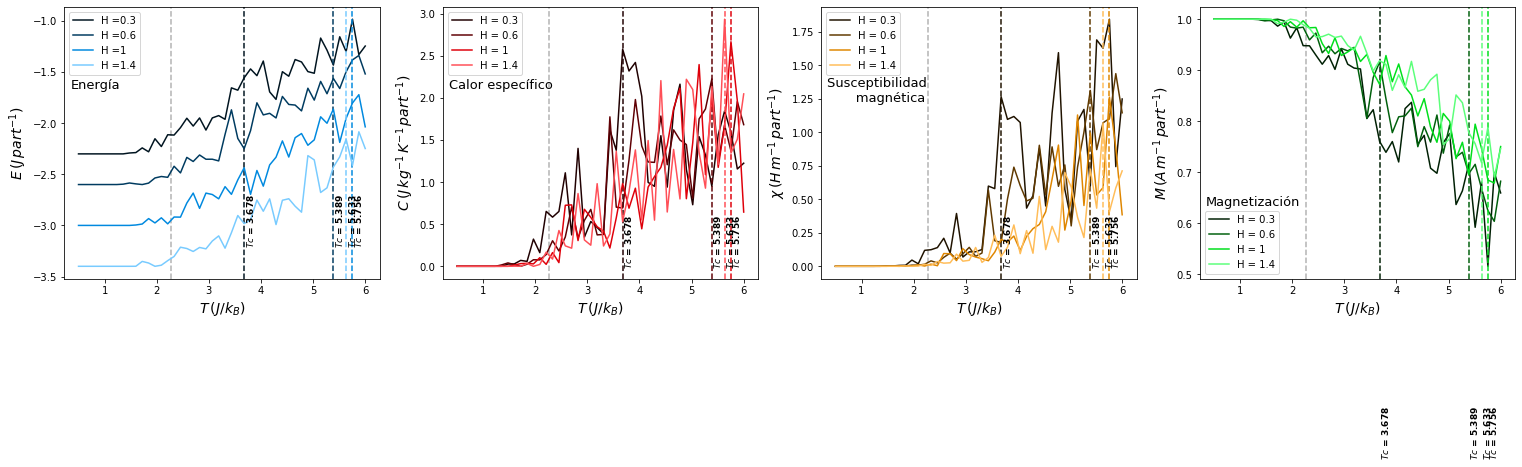

In [29]:
arrayh = [0.3,0.6,1,1.4]
J=1
kb=1
L = 15
itera = 500
arrayT = np.linspace(0.5,6,46)

variacampo(kb, J, arrayT, L, itera, arrayh)  #para el caso de la magnetización, se debe ajustar la altura de los textos de las Tc en función de L y itera, ya que
# no para todos los parámetros llega a un mismo valor y por tanto el texto aparece por encima o por debajo del lugar deseado


In [ ]:
def dominios_sincampo(kb,J,L,T,itera):
    s = np.random.choice([-1, 1], size=(L, L)) #matriz de espines inicializado con elementos aleatorios
    N = L**2 #número total de espines

    mallas = [] #lista donde se almacenan las diversas fotografias a lo largo de las iteraciones
    mallas.append(s.copy()) #sacamos la foto inicial
    timestamp1 = False #bandera para asegurarse que solo se tome una foto en el momento 1
    timestamp2 = False #bandera para asegurarse que solo se tome una foto en el momento 2

    suma0 = 0
    #calculamos la energía del sistema teniendo en cuenta la interacción con los vecinos
    for j in range(L):
        for i in range(L-1):
            suma0+=s[i][j]*s[i+1][j]
        suma0+=s[L-1][j]*s[0][j]
    for i in range(L):
        for j in range(L-1):
            suma0+=s[i][j]*s[i][j+1]
        suma0+=s[i][0]*s[i][L-1]

    E = -J*suma0 #Calculamos la energía total del sistema
    n = 0 #número iteraciones
    while n<itera:
        r = rnd.randint(0,L-1)
        l = rnd.randint(0,L-1)
        s[r][l]*=-1  #se elige un espín al azar y se cambia su valor
        suma1 = 0
        #Se calcula la energía de la nueva configuración
        for j in range(L):
            for i in range(L-1):
                suma1+=s[i][j]*s[i+1][j]
            suma1+=s[L-1][j]*s[0][j]
        for i in range(L):
            for j in range(L-1):
                suma1+=s[i][j]*s[i][j+1]
            suma1+=s[i][0]*s[i][L-1]
        E1 = -J*suma1  
        dE = E1-E
        if dE <=0:
            E += dE #se acepta el cambio
        elif dE>0:
            p = np.exp(-dE/(kb*T)) #se acepta el cambio con la probabilidad p
            t = rnd.random() #generamos num aleatorio
            if t<=p:
                E += dE #se acepta el cambio
            else:
                s[r][l]*=-1  #no se acepta el cambio
        n+=1

        if n>itera/10 and timestamp1==False:
            timestamp1 = True
            mallas.append(s.copy()) #sacamos foto en el momento intermedio 1
        if n>itera/2 and timestamp2==False:
            timestamp2 = True
            mallas.append(s.copy()) #sacamos foto en el momento intermedio 2

    mallas.append(s.copy()) #sacamos foto en el momento final

    #grafica para las fotografias en determinados instantes de tiempo

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,4)) # Create a figure with 2 rows and 4 columns
    fig.subplots_adjust(bottom=0.2)  # Adjust the bottom margin for the colorbar
    #fig.suptitle('Configuración de los espines a lo largo de las iteraciones', fontsize = 15, fontweight='demi')

    # graficamos las configuraciones
    ax1.imshow(mallas[0], cmap = 'coolwarm')
    ax1.set_title('Inicial, T<$T_c$', fontsize = 12)

    ax2.imshow(mallas[1], cmap = 'coolwarm')
    ax2.set_title('$5 \\times10^3 iteraciones, T<T_c$', fontsize = 12)

    ax3.imshow(mallas[2], cmap = 'coolwarm')
    ax3.set_title('$2.5\\times10^4 iteraciones, T<T_c$', fontsize = 12)

    ax4.imshow(mallas[3], cmap = 'coolwarm')
    ax4.set_title('$5\\times10^4 iteraciones, T<T_c$', fontsize = 12)

    # Creamos una colorbar
    cax = fig.add_axes([0.2, 0.1, 0.6, 0.05]) 
    cbar = plt.colorbar(ax4.imshow(mallas[3], cmap='coolwarm'), cax=cax, orientation='horizontal')

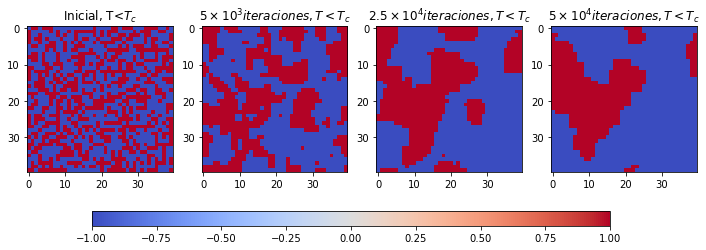

In [ ]:
kb = 1
J=1
L=40
T=1
itera=50000
dominios_sincampo(kb,J,L,T,itera)

In [77]:
#definimos una función que nos permita colocar una flecha en el centro de cada tramo indicando su dirección
def add_arrow(line, position=None, direction='right', size=15, color=None):
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )
    
def histeresis(kb,J,arrayT,L,hmax,itera, hlinspace, init_tol):
    m_inicial = 1 #
    while m_inicial > init_tol or m_inicial<0: #obligamos a trabajar a la función con una matriz inicial cuya magnetización se encuentra entre 0 y init_tol
        s_original = np.random.choice([-1, 1], size=(L, L)) #matriz de espines inicializado con elementos aleatorios
        m_inicial = np.mean(s_original)
    colors=['r','g','b']
    size = s_original.shape[0]
    N = L**2 #nº de espines
    fig, ax1 = plt.subplots(figsize=(9,6))
    tramos = [np.linspace(0,hmax, int(hlinspace/2)),np.linspace(hmax,-hmax, hlinspace),np.linspace(-hmax,hmax, hlinspace)] #tramos: 1)[0,hmax], 2)[hmax,-hmax], 3)[-hmax,hmax]
    for T in range(len(arrayT)):
        s=s_original.copy()
        M_tramos = [[],[],[]]
        for tram in range(len(tramos)):
            for h_i in range(len(tramos[tram])):
                suma0 = 0
                sumh = 0
                for i in range(L):
                    for j in range(L):
                        suma0 += 0.5*s[i][j]*(s[(i-1)%size][j]+s[(i+1)%size][j]+s[i][(j-1)%size]+s[i][(j+1)%size])
                for i in range(L):
                    for j in range(L):
                        sumh+=s[i][j]
                E = -J*suma0-(tramos[tram][h_i])*sumh #Calculamos la energía total del sistema
                n = 0 #número iteraciones
                
                while n<itera:
                    r = rnd.randint(0,L-1)
                    l = rnd.randint(0,L-1)
                    s[r][l]*=-1  #se elige un espín al azar y se cambia su valor
                    suma1 = 0
                    sumh1 = 0
                    for i in range(L):
                        for j in range(L):
                            suma1 += 0.5*s[i][j]*(s[(i-1)%size][j]+s[(i+1)%size][j]+s[i][(j-1)%size]+s[i][(j+1)%size])
                    for i in range(L):
                        for j in range(L):
                            sumh1+=s[i][j]
                    E1 = -J*suma1-(tramos[tram][h_i])*sumh1  #Se calcula la energía de la nueva configuración
                    dE = E1-E
                    if dE <=0:
                        E += dE #se acepta el cambio
                    elif dE>0:
                        p = np.exp(-dE/(kb*arrayT[T])) #se acepta el cambio con la probabilidad p
                        t = rnd.random() #generamos num aleatorio
                        if t<=p:
                            E += dE #se acepta el cambio

                        else:
                            s[r][l]*=-1 #no se acepta el cambio
                    M=(np.mean(s)) #almacenamos la magnetización
                    n+=1
                M_tramos[tram].append(M) #magnetización media
            if tram==2:
                line = ax1.plot(tramos[tram],M_tramos[tram], colors[T], label=f'T = {arrayT[T]} $J/k_B$')[0]
            else:
                line = ax1.plot(tramos[tram],M_tramos[tram], colors[T])[0]
            add_arrow(line)

    # Dibujamos líneas para los ejes M=0 y H=0
    ax1.axhline(0, color='black', linewidth=0.8)  # y=0
    ax1.axvline(0, color='black', linewidth=0.8)  # x=0
    ax1.text(0.48, 1.02, 'H=0', transform=ax1.transAxes, fontweight='demi', fontsize = 12)
    ax1.text(0.94, 0.51, 'M=0', transform=ax1.transAxes, fontweight='demi', fontsize = 12)

    # Colocamos título a los ejes
    
    ax1.set_ylabel('$M \, (A \, m^{-1} \, part^{-1}) $', fontsize = 14)
    ax1.set_xlabel('$H \,(A \, m^{-1})$', fontsize = 14)
    ax1.legend(loc='lower right')

    l, b, h, w = 0.17, .6, .25, .25
    ax2 = fig.add_axes([l, b, w, h])
    line = ax2.plot(tramos[0], M_tramos[0] , 'o', lw=3, label="inside plot")
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.text(0.05, 0.88, '$log M $', fontsize = 11, transform=ax2.transAxes, fontweight='demi')
    ax2.text(0.8, 0.05, '$log H $', fontsize = 11, transform=ax2.transAxes, fontweight='demi')
    ax2.set_ylim([0.09, 1])
    plt.show()


c:\Users\Marco\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


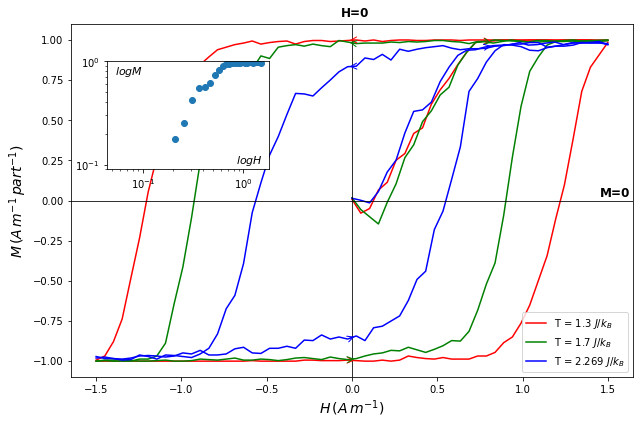

In [78]:
kb = 1
J=1
L=25
arrayT=[1.3,1.7,2.269]
itera=1000
hmax = 1.5
hlinspace = 60
init_tol=0.05
histeresis(kb,J,arrayT,L,hmax,itera, hlinspace, init_tol)